# 自建GPT训练流程 - Part 3: SFT指令微调

## 概述

本notebook演示如何对预训练模型进行**SFT (Supervised Fine-Tuning)**，让模型学会遵循用户指令。

**设备建议：** CPU 可跑（训练时间更长），GPU 可加速。

### 预训练 vs SFT 的区别

```
预训练:
  输入: "机器学习是人工智能"
  目标: 预测下一个token（续写）

SFT:
  输入: "<|user|>什么是机器学习？<|assistant|>"
  目标: 生成高质量回答，只对assistant部分计算loss
```

### SFT的核心技术点

1. **ChatML格式**: 标准化的对话模板
2. **Loss Masking**: 只对assistant回答部分计算loss
3. **指令多样性**: 多种类型的指令和回答
4. **数据质量**: 高质量的示例回答

## 环境设置

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import sys
import json
import copy

# 兼容从项目根目录或本目录运行
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..")) if os.path.basename(os.getcwd()) == "Custom_GPT_Training" else os.getcwd()
CUSTOM_GPT_DIR = os.path.join(PROJECT_ROOT, "Custom_GPT_Training")
sys.path.insert(0, CUSTOM_GPT_DIR)

from custom_gpt import (
    CustomGPT, 
    GPTConfig, 
    SimpleTokenizer,
    count_parameters
)

# 设备选择
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"使用设备: {device}")

# 可复现性
torch.manual_seed(42)
np.random.seed(42)

使用设备: cuda


## Part 1: SFT训练数据

本路线聚焦“短知识问答”，方便观察指令理解与回答质量。

输出：简洁、单句的事实性回答。


In [2]:
# SFT训练数据：从 data/ 读取（训练/验证/测试拆分）
import json
from pathlib import Path

def resolve_data_dir():
    candidates = [Path.cwd(), Path.cwd().parent]
    for base in candidates:
        data_dir = base / "data"
        if data_dir.exists():
            return str(data_dir)
    return os.path.join(os.getcwd(), "data")

DATA_DIR = resolve_data_dir()


def load_jsonl(path):
    with open(path, "r", encoding="utf-8-sig") as f:
        return [json.loads(line) for line in f if line.strip()]

SFT_DATA = load_jsonl(os.path.join(DATA_DIR, "custom_sft_train.jsonl"))
VAL_DATA = load_jsonl(os.path.join(DATA_DIR, "custom_sft_val.jsonl"))
TEST_DATA = load_jsonl(os.path.join(DATA_DIR, "custom_sft_test.jsonl"))

print(f"训练集: {len(SFT_DATA)} 条 | 验证集: {len(VAL_DATA)} 条 | 测试集: {len(TEST_DATA)} 条")
print(f"任务类型: {sorted(set(t['category'] for t in SFT_DATA))}")
print(f"示例: {SFT_DATA[0]}")


训练集: 8000 条 | 验证集: 1000 条 | 测试集: 1000 条
任务类型: ['知识问答']
示例: {'instruction': '用一句话解释：深度学习是什么？', 'response': '深度学习是用多层神经网络学习数据表示的方法。', 'category': '知识问答', 'metric': 'text', 'expected': '深度学习是用多层神经网络学习数据表示的方法。'}


## Part 2: ChatML格式化

In [3]:
class ChatMLFormatter:
    """
    ChatML格式化器
    
    将(指令, 回答)转换为标准ChatML格式:
    <|system|>你是一个有帮助的AI助手。<|endoftext|>
    <|user|>用户指令<|endoftext|>
    <|assistant|>模型回答<|endoftext|>
    """
    
    SYSTEM_PROMPT = "你是一个有帮助的AI助手。"
    
    # 特殊token
    SYSTEM_TOKEN = "<|system|>"
    USER_TOKEN = "<|user|>"
    ASSISTANT_TOKEN = "<|assistant|>"
    END_TOKEN = "<|endoftext|>"
    
    @classmethod
    def format(cls, instruction, response, include_system=True):
        """格式化单条数据"""
        parts = []
        
        if include_system:
            parts.append(f"{cls.SYSTEM_TOKEN}{cls.SYSTEM_PROMPT}{cls.END_TOKEN}")
        
        parts.append(f"{cls.USER_TOKEN}{instruction}{cls.END_TOKEN}")
        parts.append(f"{cls.ASSISTANT_TOKEN}{response}{cls.END_TOKEN}")
        
        return "\n".join(parts)
    
    @classmethod
    def format_prompt_only(cls, instruction, include_system=True):
        """只格式化prompt（用于推理）"""
        parts = []
        
        if include_system:
            parts.append(f"{cls.SYSTEM_TOKEN}{cls.SYSTEM_PROMPT}{cls.END_TOKEN}")
        
        parts.append(f"{cls.USER_TOKEN}{instruction}{cls.END_TOKEN}")
        parts.append(f"{cls.ASSISTANT_TOKEN}")  # 等待模型续写
        
        return "\n".join(parts)

# 示例
sample = SFT_DATA[0]
formatted = ChatMLFormatter.format(sample['instruction'], sample['response'])
print("ChatML格式示例:")
print("=" * 50)
print(formatted)

ChatML格式示例:
<|system|>你是一个有帮助的AI助手。<|endoftext|>
<|user|>用一句话解释：深度学习是什么？<|endoftext|>
<|assistant|>深度学习是用多层神经网络学习数据表示的方法。<|endoftext|>


## Part 3: SFT数据集（带Loss Masking）

In [4]:
class SFTDataset(Dataset):
    """
    SFT数据集
    
    关键: 只对assistant回答部分计算loss
    
    通过设置labels中非assistant部分为-100，
    CrossEntropyLoss会自动忽略这些位置。
    """
    
    def __init__(self, data, tokenizer, max_length=256):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = data
        
        # 字符级分词器会直接处理ChatML标记；仅在word模式时扩充词表
        if getattr(tokenizer, "mode", "char") != "char" and hasattr(tokenizer, "add_special_token"):
            special_tokens = [
                ChatMLFormatter.SYSTEM_TOKEN,
                ChatMLFormatter.USER_TOKEN,
                ChatMLFormatter.ASSISTANT_TOKEN,
                ChatMLFormatter.END_TOKEN
            ]
            for token in special_tokens:
                if token not in tokenizer.token_to_id:
                    tokenizer.add_special_token(token)
        
        print(f"SFT数据集: {len(data)} 条")
        print(f"最大长度: {max_length}")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        # 格式化
        full_text = ChatMLFormatter.format(
            item['instruction'], 
            item['response']
        )
        
        # 编码完整文本
        full_ids = self.tokenizer.encode(full_text, add_bos=True, add_eos=False)
        
        # 找到assistant回答开始的位置
        # 编码到assistant token为止的部分
        prompt_text = ChatMLFormatter.format_prompt_only(item['instruction'])
        prompt_ids = self.tokenizer.encode(prompt_text, add_bos=True, add_eos=False)
        assistant_start = len(prompt_ids)
        
        # 截断或填充
        if len(full_ids) > self.max_length:
            full_ids = full_ids[:self.max_length]
            assistant_start = min(assistant_start, self.max_length)
        
        # 创建labels（只对assistant部分计算loss）
        labels = [-100] * len(full_ids)  # -100会被CrossEntropyLoss忽略
        for i in range(assistant_start, len(full_ids)):
            labels[i] = full_ids[i]  # 只有assistant部分有label
        
        # 填充
        pad_len = self.max_length - len(full_ids)
        if pad_len > 0:
            full_ids = full_ids + [self.tokenizer.pad_token_id] * pad_len
            labels = labels + [-100] * pad_len  # padding部分也忽略
        
        # 创建attention mask
        attention_mask = [1 if id != self.tokenizer.pad_token_id else 0 for id in full_ids]
        
        return {
            'input_ids': torch.tensor(full_ids[:-1], dtype=torch.long),  # 输入不含最后一个
            'labels': torch.tensor(labels[1:], dtype=torch.long),  # label右移一位
            'attention_mask': torch.tensor(attention_mask[:-1], dtype=torch.float)
        }

In [5]:
# 加载预训练的tokenizer和模型
CHECKPOINT_DIR = os.path.join(PROJECT_ROOT, "models", "custom_gpt")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# 加载tokenizer（优先使用预训练构建的词表）
tokenizer_path = os.path.join(CHECKPOINT_DIR, "tokenizer.pkl")
if os.path.exists(tokenizer_path):
    tokenizer = SimpleTokenizer.load(tokenizer_path)
    print(f"加载tokenizer, 词表大小: {len(tokenizer)}")
else:
    print("未找到预训练tokenizer，使用SFT数据构建新词表...")
    tokenizer = SimpleTokenizer(vocab_size=5000, mode="char", min_freq=1)
    tokenizer.build_vocab([
        record["instruction"] + " " + record["response"] for record in SFT_DATA
    ])
    tokenizer.save(tokenizer_path)
    print(f"新词表已保存, 词表大小: {len(tokenizer)}")

# 创建SFT数据集
MAX_LENGTH = 256
BATCH_SIZE = 8

train_dataset = SFTDataset(SFT_DATA, tokenizer, max_length=MAX_LENGTH)
val_dataset = SFTDataset(VAL_DATA, tokenizer, max_length=MAX_LENGTH)

print(f"\n训练集: {len(train_dataset)} 样本")
print(f"验证集: {len(val_dataset)} 样本")

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


加载tokenizer, 词表大小: 381
SFT数据集: 8000 条
最大长度: 256
SFT数据集: 1000 条
最大长度: 256

训练集: 8000 样本
验证集: 1000 样本


In [6]:
# 可视化Loss Masking
sample = train_dataset[0]

print("Loss Masking可视化:")
print("=" * 60)

input_ids = sample['input_ids'].tolist()
labels = sample['labels'].tolist()

# 显示前50个token
print("\nToken ID | Label | 是否计算Loss")
print("-" * 40)
for i in range(min(50, len(input_ids))):
    token = tokenizer.decode([input_ids[i]], skip_special=False)
    label = labels[i]
    compute_loss = "✓" if label != -100 else "✗"
    print(f"{input_ids[i]:6d} | {label:6} | {compute_loss}  '{token[:10]}'")

print(f"\n总token数: {len(input_ids)}")
print(f"计算loss的token数: {sum(1 for l in labels if l != -100)}")

Loss Masking可视化:

Token ID | Label | 是否计算Loss
----------------------------------------
     1 |   -100 | ✗  '<BOS>'
   370 |   -100 | ✗  '<'
   245 |   -100 | ✗  '|'
   122 |   -100 | ✗  's'
   374 |   -100 | ✗  'y'
   122 |   -100 | ✗  's'
   103 |   -100 | ✗  't'
    99 |   -100 | ✗  'e'
   121 |   -100 | ✗  'm'
   245 |   -100 | ✗  '|'
   371 |   -100 | ✗  '>'
   375 |   -100 | ✗  '你'
   106 |   -100 | ✗  '是'
    43 |   -100 | ✗  '一'
   160 |   -100 | ✗  '个'
   330 |   -100 | ✗  '有'
   376 |   -100 | ✗  '帮'
   373 |   -100 | ✗  '助'
   101 |   -100 | ✗  '的'
   240 |   -100 | ✗  'A'
   377 |   -100 | ✗  'I'
   373 |   -100 | ✗  '助'
   378 |   -100 | ✗  '手'
     4 |   -100 | ✗  '。'
   370 |   -100 | ✗  '<'
   245 |   -100 | ✗  '|'
    99 |   -100 | ✗  'e'
   105 |   -100 | ✗  'n'
   124 |   -100 | ✗  'd'
   102 |   -100 | ✗  'o'
   180 |   -100 | ✗  'f'
   103 |   -100 | ✗  't'
    99 |   -100 | ✗  'e'
   372 |   -100 | ✗  'x'
   103 |   -100 | ✗  't'
   245 |   -100 | ✗  '|'
   371 | 

## Part 4: SFT Trainer

In [7]:
class SFTTrainer:
    """
    SFT Trainer
    
    与预训练Trainer的区别:
    1. 使用带masking的labels
    2. 通常使用较小的学习率
    3. 训练轮次较少
    """
    
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        lr=5e-5,  # SFT通常用较小学习率
        weight_decay=0.01,
        warmup_steps=50,
        max_grad_norm=1.0,
        device='cpu'
    ):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.max_grad_norm = max_grad_norm
        self.warmup_steps = warmup_steps
        self.base_lr = lr
        
        # 优化器
        self.optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay
        )
        
        # 训练历史
        self.train_losses = []
        self.val_losses = []
        self.global_step = 0
    
    def get_lr(self, step, total_steps):
        """学习率调度"""
        if step < self.warmup_steps:
            return self.base_lr * step / self.warmup_steps
        else:
            progress = (step - self.warmup_steps) / (total_steps - self.warmup_steps)
            return self.base_lr * 0.5 * (1 + np.cos(np.pi * progress))
    
    def compute_loss(self, logits, labels):
        """
        计算loss（只对非-100的位置）
        
        CrossEntropyLoss默认ignore_index=-100
        """
        loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
        
        # Reshape: (batch, seq, vocab) -> (batch*seq, vocab)
        logits_flat = logits.view(-1, logits.size(-1))
        labels_flat = labels.view(-1)
        
        return loss_fn(logits_flat, labels_flat)
    
    def train_epoch(self, epoch, total_epochs):
        """训练一个epoch"""
        self.model.train()
        total_loss = 0
        total_steps = len(self.train_loader) * total_epochs
        
        pbar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{total_epochs}")
        for batch in pbar:
            # 更新学习率
            lr = self.get_lr(self.global_step, total_steps)
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr
            
            # 准备数据
            input_ids = batch['input_ids'].to(self.device)
            labels = batch['labels'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            
            # 前向传播
            outputs = self.model(input_ids, attention_mask=attention_mask)
            logits = outputs['logits']
            
            # 计算loss（只对assistant部分）
            loss = self.compute_loss(logits, labels)
            
            # 反向传播
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
            self.optimizer.step()
            
            # 记录
            total_loss += loss.item()
            self.train_losses.append(loss.item())
            self.global_step += 1
            
            pbar.set_postfix({'loss': f"{loss.item():.4f}", 'lr': f"{lr:.2e}"})
        
        return total_loss / len(self.train_loader)
    
    @torch.no_grad()
    def evaluate(self):
        """验证集评估"""
        self.model.eval()
        total_loss = 0
        
        for batch in self.val_loader:
            input_ids = batch['input_ids'].to(self.device)
            labels = batch['labels'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            
            outputs = self.model(input_ids, attention_mask=attention_mask)
            loss = self.compute_loss(outputs['logits'], labels)
            total_loss += loss.item()
        
        avg_loss = total_loss / len(self.val_loader)
        self.val_losses.append(avg_loss)
        return avg_loss
    
    def train(self, epochs, save_dir=None):
        """完整训练流程"""
        print(f"\n开始SFT训练")
        print(f"{'='*50}")
        print(f"  模型参数: {count_parameters(self.model)}")
        print(f"  训练样本: {len(self.train_loader.dataset)}")
        print(f"  Epochs: {epochs}")
        print(f"{'='*50}\n")
        
        best_val_loss = float('inf')
        
        for epoch in range(epochs):
            train_loss = self.train_epoch(epoch, epochs)
            val_loss = self.evaluate()
            
            print(f"\nEpoch {epoch+1}/{epochs}:")
            print(f"  训练Loss: {train_loss:.4f}")
            print(f"  验证Loss: {val_loss:.4f}")
            
            if save_dir and val_loss < best_val_loss:
                best_val_loss = val_loss
                self.model.save_pretrained(os.path.join(save_dir, "sft_model"))
                print(f"  ✓ 保存最佳模型")
        
        return {'train_losses': self.train_losses, 'val_losses': self.val_losses}

## Part 5: 执行SFT训练

In [8]:
# 加载预训练模型
pretrained_path = os.path.join(CHECKPOINT_DIR, "pretrained_model")

if os.path.exists(pretrained_path):
    print("加载预训练模型...")
    model = CustomGPT.from_pretrained(pretrained_path)
else:
    print("预训练模型不存在，创建新模型...")
    config = GPTConfig(
        vocab_size=len(tokenizer),
        max_seq_len=MAX_LENGTH,
        d_model=384,
        n_heads=6,
        n_layers=6,
        d_ff=1536
    )
    model = CustomGPT(config)

print(f"模型参数: {count_parameters(model)}")

加载预训练模型...
Model loaded from c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\pretrained_model
模型参数: 14.31M


In [9]:
# 创建Trainer
trainer = SFTTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    lr=5e-5,  # SFT用较小学习率
    weight_decay=0.01,
    warmup_steps=20,
    device=device
)

# 执行训练
EPOCHS = 5
history = trainer.train(epochs=EPOCHS, save_dir=CHECKPOINT_DIR)


开始SFT训练
  模型参数: 14.31M
  训练样本: 8000
  Epochs: 5



Epoch 1/5:   0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 1/5:
  训练Loss: 0.3582
  验证Loss: 0.0040
Model saved to c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\sft_model
  ✓ 保存最佳模型


Epoch 2/5:   0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 2/5:
  训练Loss: 0.0039
  验证Loss: 0.0015
Model saved to c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\sft_model
  ✓ 保存最佳模型


Epoch 3/5:   0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 3/5:
  训练Loss: 0.0020
  验证Loss: 0.0009
Model saved to c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\sft_model
  ✓ 保存最佳模型


Epoch 4/5:   0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 4/5:
  训练Loss: 0.0012
  验证Loss: 0.0007
Model saved to c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\sft_model
  ✓ 保存最佳模型


Epoch 5/5:   0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 5/5:
  训练Loss: 0.0011
  验证Loss: 0.0006
Model saved to c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\sft_model
  ✓ 保存最佳模型


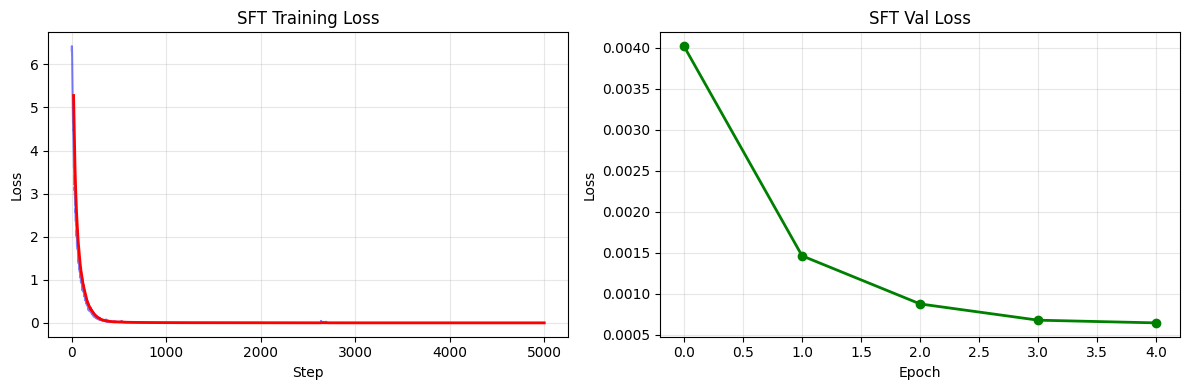

In [10]:
# 可视化训练过程
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 训练Loss
axes[0].plot(history['train_losses'], 'b-', alpha=0.5)
window = 20
if len(history['train_losses']) > window:
    smoothed = np.convolve(history['train_losses'], np.ones(window)/window, mode='valid')
    axes[0].plot(range(window-1, len(history['train_losses'])), smoothed, 'r-', linewidth=2)
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('SFT Training Loss')
axes[0].grid(True, alpha=0.3)

# 验证Loss
axes[1].plot(history['val_losses'], 'g-o', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('SFT Val Loss')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 6: 测试SFT模型

In [11]:
def chat(model, tokenizer, instruction, max_new_tokens=100, temperature=0.2):
    """
    与SFT模型对话
    """
    model.eval()
    
    # 格式化prompt
    prompt = ChatMLFormatter.format_prompt_only(instruction)
    input_ids = torch.tensor([tokenizer.encode(prompt, add_bos=True, add_eos=False)]).to(device)
    
    # 生成
    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_k=None,
            do_sample=False
        )
    
    # 解码
    full_response = tokenizer.decode(output_ids[0].tolist())
    
    # 提取assistant回答部分
    if ChatMLFormatter.ASSISTANT_TOKEN in full_response:
        response = full_response.split(ChatMLFormatter.ASSISTANT_TOKEN)[-1]
        if ChatMLFormatter.END_TOKEN in response:
            response = response.split(ChatMLFormatter.END_TOKEN)[0]
    else:
        response = full_response
    
    return response.strip()

In [12]:
# 加载SFT模型
sft_model = CustomGPT.from_pretrained(
    os.path.join(CHECKPOINT_DIR, "sft_model")
).to(device)

print("加载SFT模型完成")

Model loaded from c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\sft_model
加载SFT模型完成


In [13]:
# 测试问答
test_samples = TEST_DATA[:5]

print("SFT模型问答测试(来自测试集):")
print("=" * 60)

for item in test_samples:
    instruction = item["instruction"]
    expected = item["expected"]
    response = chat(sft_model, tokenizer, instruction)
    print(f"\n指令: {instruction}")
    print(f"期望: {expected}")
    print(f"输出: {response}")
    print("-" * 40)

SFT模型问答测试(来自测试集):

指令: 用一句话解释：深度学习是什么？
期望: 深度学习是用多层神经网络学习数据表示的方法。
输出: 深度学习是用多层神经网络学习数据表示的方法。
----------------------------------------

指令: 用不超过40字回答：机器学习是什么？
期望: 机器学习是让模型从数据中学习规律并做预测。
输出: 机器学习是让模型从数据中学习规律并做预测。
----------------------------------------

指令: 简要说明：监督学习是什么？
期望: 监督学习用带标签的数据训练模型。
输出: 监督学习用带标签的数据训练模型。
----------------------------------------

指令: 回答问题：无监督学习是什么？
期望: 无监督学习从无标签数据中发现结构。
输出: 无监督学习从无标签数据中发现结构。
----------------------------------------

指令: 用一句话解释：强化学习是什么？
期望: 强化学习通过奖励信号学习策略。
输出: 强化学习通过奖励信号学习策略。
----------------------------------------


## Part 7: Base模型 vs SFT模型对比

In [14]:
# 加载预训练base模型进行对比
pretrained_path = os.path.join(CHECKPOINT_DIR, "pretrained_model")
if os.path.exists(pretrained_path):
    base_model = CustomGPT.from_pretrained(pretrained_path).to(device)
    
    print("Base模型 vs SFT模型对比:")
    print("=" * 60)
    
    test_instruction = "用一句话解释：深度学习是什么？"
    
    # Base模型（直接续写，不理解指令）
    base_model.eval()
    base_input = torch.tensor([tokenizer.encode(test_instruction, add_bos=True, add_eos=False)]).to(device)
    with torch.no_grad():
        base_output = base_model.generate(base_input, max_new_tokens=50, temperature=0.7)
    base_response = tokenizer.decode(base_output[0].tolist())
    
    # SFT模型（理解指令，生成回答）
    sft_response = chat(sft_model, tokenizer, test_instruction)
    
    print(f"\n指令: {test_instruction}")
    print(f"\n[Base模型] (直接续写):")
    print(f"{base_response}")
    print(f"\n[SFT模型] (理解指令):")
    print(f"{sft_response}")
else:
    print("Base模型不存在，跳过对比")

Model loaded from c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\pretrained_model
Base模型 vs SFT模型对比:

指令: 用一句话解释：深度学习是什么？

[Base模型] (直接续写):
用一解释深度学习是。征程要置学制应应程要置证与源

[SFT模型] (理解指令):
深度学习是用多层神经网络学习数据表示的方法。


## 总结

### 本notebook完成的内容

1. **ChatML格式化**
   - 标准化对话模板
   - 区分system/user/assistant角色

2. **SFT数据集**
   - (指令, 回答)对
   - **Loss Masking**: 只对assistant部分计算loss
   - 通过设置labels=-100忽略非目标token

3. **SFT训练**
   - 较小学习率(5e-5)
   - 较少训练轮次
   - 从预训练模型初始化

### SFT后模型的变化

- **之前**: 只会续写文本，不理解指令
- **之后**: 理解用户意图，生成针对性回答

### 下一步: DPO训练 (04_DPO_Training.ipynb)

SFT后的模型仍可能生成不够好的回答。DPO让模型学习人类偏好，选择更好的回答方式。